In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
image_folder = '/content/drive/MyDrive/AMLAA/VQA_RAD_Image_Folder'
excel_path = '/content/drive/MyDrive/AMLAA/VQA_RAD_Dataset_Public.xlsx'

In [ ]:
import pandas as pd

df = pd.read_excel(excel_path)
print(df.head())

   QID_unique  QID_para                            QID_linked  \
0           0  freeform  03f451ca-de62-4617-9679-e836026a7642   
1           1  freeform  06e26b2c-04b9-42bc-8e98-1de30a0f7682   
2           2  freeform  0d0e8b6b-7753-4788-9b6d-dc7f25250c3f   
3           3  freeform  0e90b6bc-265f-490b-a039-509b9907a3cb   
4           4  freeform  1179f612-12e0-4dda-aee0-f14a5200be7b   

                                        IMAGEID_case  \
0  https://medpix.nlm.nih.gov/case?id=48e1dd0e-85...   
1  https://medpix.nlm.nih.gov/case?id=b197277b-69...   
2  https://medpix.nlm.nih.gov/case?id=b197277b-69...   
3  https://medpix.nlm.nih.gov/case?id=19aa8a2b-35...   
4  https://medpix.nlm.nih.gov/case?id=b197277b-69...   

                                             IMAGEID IMAGEORGAN  \
0  https://medpix.nlm.nih.gov/images/full/synpic5...       HEAD   
1  https://medpix.nlm.nih.gov/images/full/synpic2...      CHEST   
2  https://medpix.nlm.nih.gov/images/full/synpic2...      CHEST   
3  h

In [ ]:
import cv2
import numpy as np
import os

img_size = (224, 224)

def load_image(filename):
    img_path = os.path.join(image_folder, filename)
    if not os.path.exists(img_path):
        print(f"Image not found: {img_path}")
        return None
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, img_size)
    img = img / 255.0  # normalize
    return img

In [ ]:
# separate close and open answer
# CLOSED answers
df_closed = df[df['A_TYPE'] == 'CLOSED'].reset_index(drop=True)
closed_questions = df_closed['QUESTION'].tolist()
closed_answers = df_closed['ANSWER'].tolist()

# OPEN answers
df_open = df[df['A_TYPE'] != 'CLOSED'].reset_index(drop=True)
open_questions = df_open['QUESTION'].tolist()
open_answers = df_open['ANSWER'].tolist()


In [ ]:
# tokenize and pad question
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# CLOSED questions
tokenizer_q_closed = Tokenizer()
tokenizer_q_closed.fit_on_texts(closed_questions)
q_seq_closed = tokenizer_q_closed.texts_to_sequences(closed_questions)
q_padded_closed = pad_sequences(q_seq_closed, padding='post')

In [ ]:
# OPEN questions
tokenizer_q_open = Tokenizer()
tokenizer_q_open.fit_on_texts(open_questions)
q_seq_open = tokenizer_q_open.texts_to_sequences(open_questions)
q_padded_open = pad_sequences(q_seq_open, padding='post')

In [ ]:
# encode closed answer
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

le_closed = LabelEncoder()
closed_cat = le_closed.fit_transform(closed_answers)
closed_cat = to_categorical(closed_cat)

In [ ]:
# Replace missing answers with empty string
df_open['ANSWER'] = df_open['ANSWER'].fillna('')
open_answers = df_open['ANSWER'].astype(str).tolist()

In [ ]:
tokenizer_a_open = Tokenizer()
tokenizer_a_open.fit_on_texts(open_answers)
a_seq_open = tokenizer_a_open.texts_to_sequences(open_answers)
a_padded = pad_sequences(a_seq_open, padding='post')

In [ ]:
# Load images and pair with questions/answers
# CLOSED
X_images_closed, X_q_closed, y_closed_final = [], [], []

for idx, row in df_closed.iterrows():
    img_file = os.path.basename(row['IMAGEID'])
    img = load_image(img_file)
    if img is None:
        continue
    X_images_closed.append(img)
    X_q_closed.append(q_padded_closed[idx])
    y_closed_final.append(closed_cat[idx])

X_images_closed = np.array(X_images_closed)
X_q_closed = np.array(X_q_closed)
y_closed_final = np.array(y_closed_final)

# OPEN
X_images_open, X_q_open, y_open_final = [], [], []

for idx, row in df_open.iterrows():
    img_file = os.path.basename(row['IMAGEID'])
    img = load_image(img_file)
    if img is None:
        continue
    X_images_open.append(img)
    X_q_open.append(q_padded_open[idx])
    y_open_final.append(a_padded[idx])

X_images_open = np.array(X_images_open)
X_q_open = np.array(X_q_open)
y_open_final = np.array(y_open_final)

In [ ]:
from sklearn.model_selection import train_test_split

# ---- CLOSED ----
X_img_train_c, X_img_test_c, X_q_train_c, X_q_test_c, y_train_c, y_test_c = train_test_split(
    X_images_closed, X_q_closed, y_closed_final, test_size=0.2, random_state=42
)

# ---- OPEN ----
X_img_train_o, X_img_test_o, X_q_train_o, X_q_test_o, y_train_o, y_test_o = train_test_split(
    X_images_open, X_q_open, y_open_final, test_size=0.2, random_state=42
)

# Build model

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.layers import LSTM, Embedding, Concatenate, RepeatVector, TimeDistributed

In [ ]:
#Model for CLOSED answers (classification)
#nputs: image + question
# Outputs: categorical answer (one-hot)

# Image input
img_input_c = Input(shape=(224, 224, 3), name='image_input')
x = Conv2D(32, (3,3), activation='relu')(img_input_c)
x = MaxPooling2D((2,2))(x)
x = Conv2D(64, (3,3), activation='relu')(x)
x = MaxPooling2D((2,2))(x)
x = Flatten()(x)

# Question input
q_input_c = Input(shape=(X_q_train_c.shape[1],), name='question_input')
q = Embedding(input_dim=len(tokenizer_q_closed.word_index)+1, output_dim=64)(q_input_c)
q = LSTM(64)(q)

# Combine image + question features
combined = Concatenate()([x, q])
out_c = Dense(y_train_c.shape[1], activation='softmax')(combined)

model_closed = Model(inputs=[img_input_c, q_input_c], outputs=out_c)
model_closed.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_closed.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 222, 222,  │        896 │ image_input[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 111, 111,  │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 109, 109,  │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ question_input      │ (None, 21)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 54, 54,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 21, 64)    │     56,064 │ question_input[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 186624)    │          0 │ max_pooling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 64)        │     33,024 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 186688)    │          0 │ flatten[0][0],    │
│ (Concatenate)       │                   │            │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 72)        │ 13,441,608 │ concatenate[0][0] │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 13,550,088 (51.69 MB)

 Trainable params: 13,550,088 (51.69 MB)

 Non-trainable params: 0 (0.00 B)

Model for OPEN answers (seq2seq)

Inputs: image + question

Outputs: sequence of tokens for the answer

In [ ]:
# ---- Image input branch ----
img_input_o = Input(shape=(224, 224, 3), name='image_input')
x = Conv2D(32, (3,3), activation='relu')(img_input_o)
x = MaxPooling2D((2,2))(x)
x = Conv2D(64, (3,3), activation='relu')(x)
x = MaxPooling2D((2,2))(x)
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = RepeatVector(y_train_o.shape[1])(x)  # repeat for each answer token

# ---- Question input branch ----
q_input_o = Input(shape=(X_q_train_o.shape[1],), name='question_input')
q = Embedding(input_dim=len(tokenizer_q_open.word_index)+1, output_dim=64)(q_input_o)
q = LSTM(128, return_sequences=False)(q)  # output 2D
q = RepeatVector(y_train_o.shape[1])(q)   # repeat for each answer token

# ---- Combine image + question ----
combined_o = Concatenate(axis=-1)([x, q])
out_o = TimeDistributed(Dense(len(tokenizer_a_open.word_index)+1, activation='softmax'))(combined_o)

# ---- Define model ----
model_open = Model(inputs=[img_input_o, q_input_o], outputs=out_o)
model_open.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_open.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 222, 222,  │        896 │ image_input[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 111, 111,  │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 109, 109,  │     18,496 │ max_pooling2d_2[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 54, 54,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ question_input      │ (None, 22)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 186624)    │          0 │ max_pooling2d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 22, 64)    │     45,312 │ question_input[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │ 47,776,000 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 128)       │     98,816 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector       │ (None, 17, 256)   │          0 │ dense_1[0][0]     │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_1     │ (None, 17, 128)   │          0 │ lstm_1[0][0]      │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 17, 384)   │          0 │ repeat_vector[0]… │
│ (Concatenate)       │                   │            │ repeat_vector_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed    │ (None, 17, 601)   │    231,385 │ concatenate_1[0]… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 48,170,905 (183.76 MB)

 Trainable params: 48,170,905 (183.76 MB)

 Non-trainable params: 0 (0.00 B)

valid


In [ ]:
y_train_o_reshaped = np.expand_dims(y_train_o, -1)
y_test_o_reshaped = np.expand_dims(y_test_o, -1)

# model_open.fit([X_img_train_o, X_q_train_o], y_train_o_reshaped,
#                validation_data=([X_img_test_o, X_q_test_o], y_test_o_reshaped),
#                epochs=5, batch_size=16)

history = model_open.fit(
    [X_img_train_o, X_q_train_o],
    y_train_o_reshaped,
    validation_data=([X_img_test_o, X_q_test_o], y_test_o_reshaped),
    epochs=10,
    batch_size=16
)

Epoch 1/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 115s 2s/step - accuracy: 0.7759 - loss: 2.7219 - val_accuracy: 0.8626 - val_loss: 2.2140
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 104s 2s/step - accuracy: 0.8541 - loss: 2.3522 - val_accuracy: 0.8626 - val_loss: 2.2140
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.8568 - loss: 2.3075 - val_accuracy: 0.8626 - val_loss: 2.2140
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 104s 2s/step - accuracy: 0.8564 - loss: 2.3142 - val_accuracy: 0.8626 - val_loss: 2.2140
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 151s 2s/step - accuracy: 0.8608 - loss: 2.2436 - val_accuracy: 0.8626 - val_loss: 2.2140
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 135s 2s/step - accuracy: 0.8553 - loss: 2.3320 - val_accuracy: 0.8626 - val_loss: 2.2140
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 140s 2s/step - accuracy: 0.8477 - loss: 2.4541 - val_accuracy: 0.8626 - val_loss: 2.2140
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 109s 2s/step - accuracy: 0.8568 - loss: 2.3080 - val_accuracy: 0.8626 - v

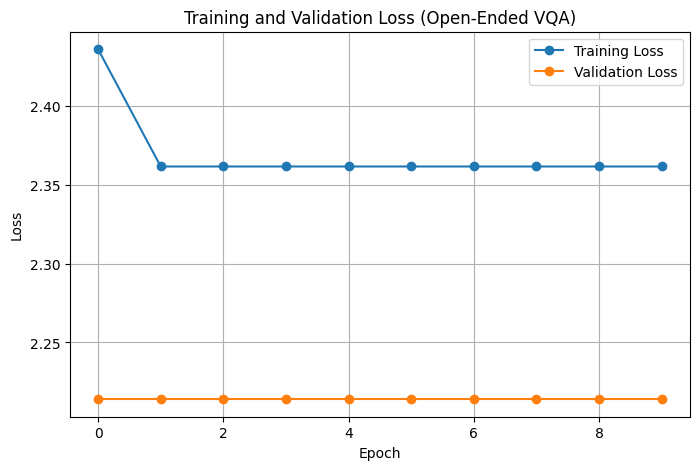

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], marker='o')
plt.plot(history.history['val_loss'], marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss (Open-Ended VQA)')
plt.legend(['Training Loss', 'Validation Loss'])
plt.grid(True)
plt.show()

In [ ]:
test_loss, test_accuracy = model_open.evaluate(
    [X_img_test_o, X_q_test_o],
    y_test_o_reshaped,
    batch_size=16
)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 372ms/step - accuracy: 0.8575 - loss: 2.2975
Test Loss: 2.214003086090088
Test Accuracy: 0.8626424670219421


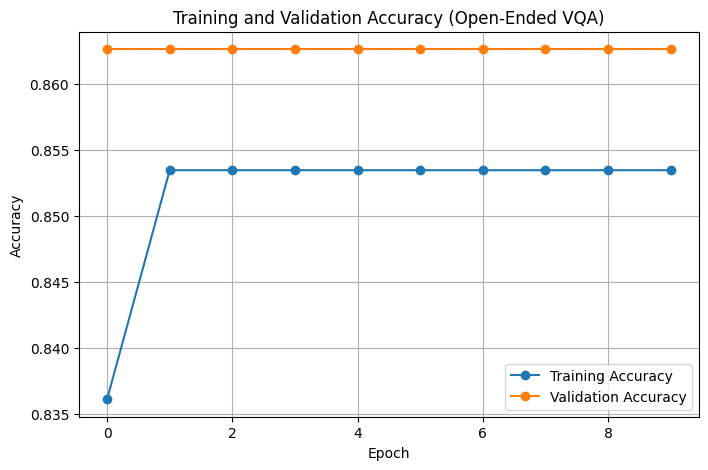

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(history.history['accuracy'], marker='o')
plt.plot(history.history['val_accuracy'], marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy (Open-Ended VQA)')
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.grid(True)
plt.show()

In [ ]:
# FIT CLOSED QUESTION
history_closed = model_closed.fit(
    [X_img_train_c, X_q_train_c],
    y_train_c,
    validation_data=([X_img_test_c, X_q_test_c], y_test_c),
    epochs=10,
    batch_size=16
)

Epoch 1/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 102s 2s/step - accuracy: 0.3316 - loss: 2.2344 - val_accuracy: 0.4308 - val_loss: 2.2039
Epoch 2/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 139s 1s/step - accuracy: 0.5598 - loss: 1.3039 - val_accuracy: 0.4654 - val_loss: 2.0057
Epoch 3/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 147s 2s/step - accuracy: 0.6111 - loss: 1.0341 - val_accuracy: 0.4577 - val_loss: 1.9343
Epoch 4/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 0.6413 - loss: 0.9377 - val_accuracy: 0.4923 - val_loss: 2.3679
Epoch 5/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 153s 2s/step - accuracy: 0.6464 - loss: 0.8659 - val_accuracy: 0.5269 - val_loss: 2.0287
Epoch 6/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 106s 2s/step - accuracy: 0.7049 - loss: 0.8025 - val_accuracy: 0.5231 - val_loss: 1.9135
Epoch 7/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 135s 2s/step - accuracy: 0.6990 - loss: 0.7574 - val_accuracy: 0.5577 - val_loss: 1.9921
Epoch 8/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 144s 2s/step - accuracy: 0.7377 - loss: 0.6467 - val_accuracy: 0.5462 - va

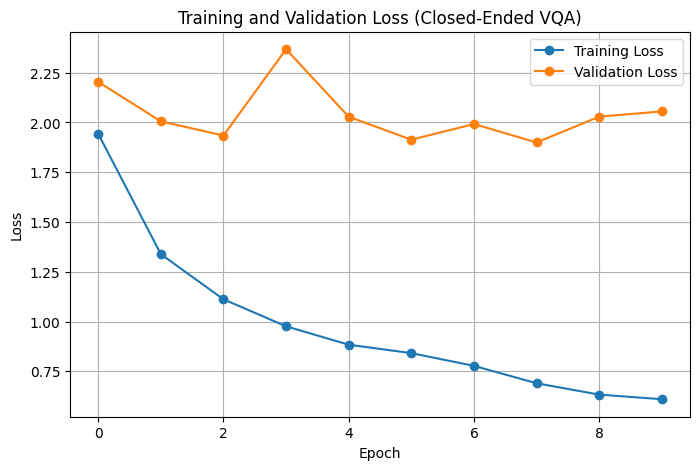

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(history_closed.history['loss'], marker='o')
plt.plot(history_closed.history['val_loss'], marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss (Closed-Ended VQA)')
plt.legend(['Training Loss', 'Validation Loss'])
plt.grid(True)
plt.show()

In [ ]:
# history_closed = model_closed.fit(
#     [X_img_train_c, X_q_train_c],
#     y_train_c,
#     validation_data=([X_img_test_c, X_q_test_c], y_test_c),
#     epochs=5,
#     batch_size=16
# )
# print("Test Accuracy:", test_accuracy)
test_loss_c, test_accuracy_c = model_closed.evaluate(
    [X_img_test_c, X_q_test_c],
    y_test_c,
    batch_size=16
)

print("Closed Test Loss:", test_loss_c)
print("Closed Test Accuracy:", test_accuracy_c)

17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 356ms/step - accuracy: 0.5382 - loss: 2.0487
Closed Test Loss: 2.055514097213745
Closed Test Accuracy: 0.5346153974533081


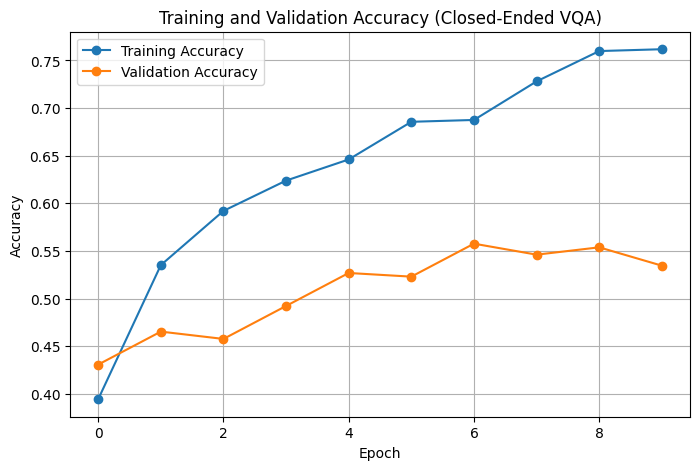

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(history_closed.history['accuracy'], marker='o')
plt.plot(history_closed.history['val_accuracy'], marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy (Closed-Ended VQA)')
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.grid(True)
plt.grid(True)
plt.show()

In [ ]:
test_loss_c, test_accuracy_c = model_closed.evaluate(
    [X_img_test_c, X_q_test_c],
    y_test_c,
    batch_size=16
)

print("Closed Test Loss:", test_loss_c)
print("Closed Test Accuracy:", test_accuracy_c)

17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 391ms/step - accuracy: 0.5382 - loss: 2.0487
Closed Test Loss: 2.055514097213745
Closed Test Accuracy: 0.5346153974533081
